In [9]:
# Instalação de pacotes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from scipy.stats import uniform, randint

# Configuração para visualização
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# --- CARREGAMENTO DOS DADOS ---
try:
    df = pd.read_csv('lending_club_loans_processed.csv')
    print("Dados carregados via arquivo local (CSV).")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado. Certifique-se de que o dataset está na mesma pasta.")

# Limpeza básica nos nomes das colunas
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

print(f"Shape do DataFrame: {df.shape}")
display(df.head())

Dados carregados via arquivo local (CSV).
Shape do DataFrame: (125865, 124)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,target,credit_age_months,emp_length_numeric,term__60_months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source_Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint_App,disbursement_method_DirectPay
0,2500,2500,2500.0,17.27,89.47,50000.0,17.60,3,670,674,4,7,0,732,31.1,22,0,1,0,0,197169,2500,6,28167,652,6.9,0,0,149,179,3,2,0,3,0,3,1,4,1,1,14,4,8,4,7,0,0,1,3,68.4,0.0,0,0,196429,197169,700,193929,False,0,182,10,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
1,35000,35000,35000.0,11.99,778.38,128000.0,6.46,0,685,689,0,17,0,14277,27.4,46,0,1,0,321,146867,52200,3,8639,17248,35.6,0,0,206,310,19,3,5,99,15,1,3,4,3,6,26,5,11,4,17,0,0,0,1,91.3,33.3,0,0,220950,49644,26800,71700,False,0,314,10,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,30000,30000,30000.0,15.77,1051.31,175000.0,18.50,0,725,729,1,9,0,21831,50.3,23,0,1,0,0,408118,43400,7,51015,21569,50.3,0,0,118,220,16,6,3,16,0,0,2,2,3,7,9,4,11,2,9,0,0,0,3,95.7,33.3,0,0,447599,152571,43400,146568,False,0,223,2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
3,4200,4200,4200.0,13.99,143.53,32000.0,31.02,0,705,709,2,10,0,1294,11.7,16,0,1,0,0,38865,11100,7,3887,5422,3.2,0,0,73,72,6,1,0,6,0,1,2,4,2,2,8,4,7,4,10,0,0,0,3,87.5,0.0,0,0,53161,38865,5600,42061,False,0,74,2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [3]:
# --- Engenharia de Features ---
print("--- Iniciando Engenharia de Features ---")

# 1. Criação de Razões Financeiras (Feature Engineering)
epsilon = 1e-6  # Evita divisão por zero

df['loan_to_income_ratio'] = df['loan_amnt'] / (df['annual_inc'] + epsilon)
df['revol_bal_to_income_ratio'] = df['revol_bal'] / (df['annual_inc'] + epsilon)
df['installment_to_income_ratio'] = (df['installment'] * 12) / (df['annual_inc'] + epsilon)
df['credit_history_length_years'] = df['mo_sin_old_rev_tl_op'] / 12
df['acc_open_rate'] = df['open_acc'] / (df['credit_history_length_years'] + epsilon)
df['int_rate_times_dti'] = df['int_rate'] * df['dti']

print("Novas features criadas com sucesso.")

# 2. Tratamento de Outliers (Winsorização)
# Limitamos os valores extremos ao percentil 99 para evitar distorções
features_to_clip = [
    'loan_to_income_ratio', 'revol_bal_to_income_ratio',
    'installment_to_income_ratio', 'acc_open_rate', 'int_rate_times_dti'
]

for feature in features_to_clip:
    p99 = df[feature].quantile(0.99)
    df[feature] = df[feature].clip(upper=p99)

print("Outliers tratados (Winsorização 99%).")

# 3. Limpeza Final e Separação X/y
df_final = df.astype(float).replace([np.inf, -np.inf], np.nan).fillna(0)

X = df_final.drop('target', axis=1)
y = df_final['target']

# Divisão Treino e Teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisão concluída: Treino {X_train.shape}, Teste {X_test.shape}")

--- Iniciando Engenharia de Features ---
Novas features criadas com sucesso.
Outliers tratados (Winsorização 99%).

Divisão concluída: Treino (100692, 129), Teste (25173, 129)


In [4]:
# ---Treinamento e Otimização do Modelo XGBoost---
print("--- Iniciando Otimização do XGBoost ---")

# Calcular peso para balanceamento de classes
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Definir modelo base
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist', # Otimizado para velocidade
    random_state=42
)

# Espaço de busca de hiperparâmetros
param_dist = {
    'n_estimators': randint(500, 1200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5)
}

# Configuração da Busca Aleatória
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,  # Número de combinações a testar
    scoring='roc_auc',
    cv=3,       # Validação cruzada em 3 partes
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Executar treinamento
random_search.fit(X_train, y_train)

# Salvar o melhor modelo
best_xgb = random_search.best_estimator_

print(f"\nMelhor AUC (Cross-Validation): {random_search.best_score_:.4f}")
print("Melhores Parâmetros:", random_search.best_params_)

--- Iniciando Otimização do XGBoost ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Melhor AUC (Cross-Validation): 0.7189
Melhores Parâmetros: {'colsample_bytree': np.float64(0.9238004184558861), 'gamma': np.float64(0.1743329936458647), 'learning_rate': np.float64(0.019617655109142075), 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1139, 'subsample': np.float64(0.855325405158244)}



--- Relatório de Classificação ---
              precision    recall  f1-score   support

        Pago       0.89      0.66      0.76     20167
Inadimplente       0.33      0.67      0.44      5006

    accuracy                           0.66     25173
   macro avg       0.61      0.67      0.60     25173
weighted avg       0.78      0.66      0.70     25173

AUC-ROC Final (Teste): 0.7256


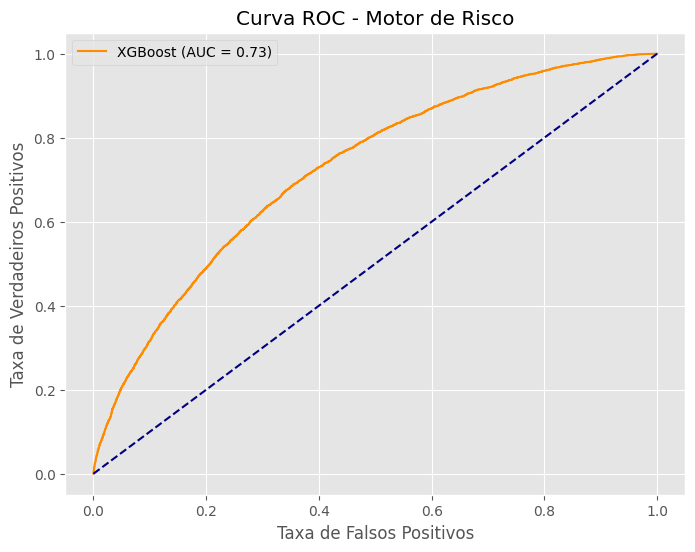

In [5]:
# --- Avaliação de Desempenho ---
# Previsões
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Métricas
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=['Pago', 'Inadimplente']))

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Final (Teste): {auc_score:.4f}")

# Curva ROC (Visualização)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Motor de Risco')
plt.legend()
plt.show()

In [6]:
# --- Extração de Features para Agente IA ---
# 1. Feature Importance
importances = best_xgb.feature_importances_
feature_names = X_train.columns

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top 10 Fatores de Risco:")
print(df_importance.head(10))

# 2. Função de Contexto para o LLM
def get_client_context(client_data, model, top_features_list):
    """Gera um resumo textual do perfil de risco do cliente."""

    prob_default = model.predict_proba(client_data)[0][1]

    # Classificação simples para o prompt
    if prob_default < 0.15:
        classe = "BAIXO RISCO (Prime)"
    elif prob_default < 0.40:
        classe = "RISCO MODERADO (Standard)"
    else:
        classe = "ALTO RISCO (Restrito)"

    context = f"""
    PERFIL DO CLIENTE:
    - Probabilidade de Inadimplência: {prob_default:.2%}
    - Segmentação de Risco: {classe}

    PRINCIPAIS INDICADORES:
    """
    for feat in top_features_list:
        val = client_data[feat].values[0]
        context += f"- {feat}: {val:.2f}\n"

    return context

print("\nFunção de contexto pronta.")

Top 10 Fatores de Risco:
                     feature  importance
3                   int_rate    0.122759
62                   grade_C    0.054017
128       int_rate_times_dti    0.049555
60           term__60_months    0.044820
101  home_ownership_MORTGAGE    0.025115
61                   grade_B    0.024660
123     loan_to_income_ratio    0.021300
8             fico_range_low    0.020087
23               avg_cur_bal    0.019535
22      acc_open_past_24mths    0.018919

Função de contexto pronta.


--- Aplicação da Política de Crédito (Decisão de Negócio) ---

Distribuição da Carteira por Segmento de Risco:
segmentacao
Alto Risco             59.31%
Médio Risco            34.44%
Baixo Risco (Prime)     6.25%
Name: proportion, dtype: object


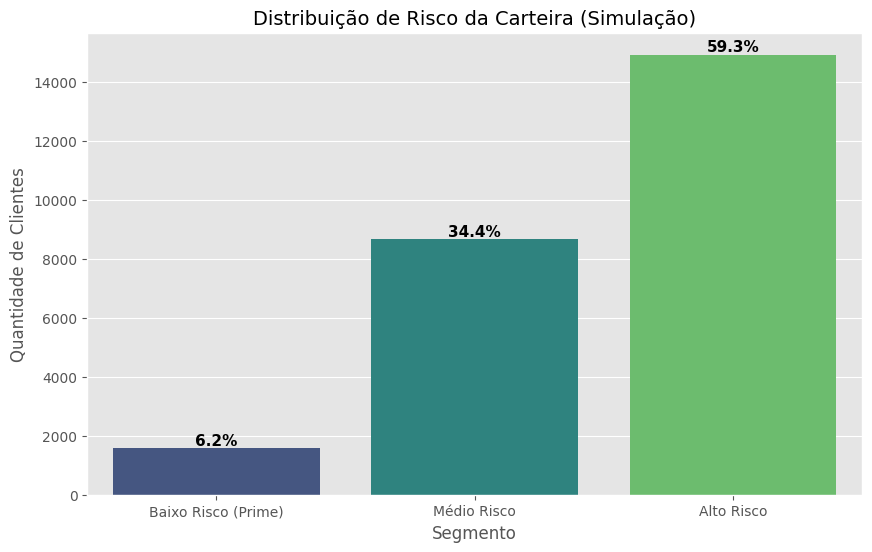


--- Exemplo de Clientes Processados (Top 5) ---


,loan_amnt,annual_inc,score_risco,segmentacao
56274,"$10,000.00","$52,000.00",64.69%,Alto Risco
14951,"$10,000.00","$80,000.00",38.37%,Médio Risco
61293,"$32,000.00","$102,000.00",52.65%,Alto Risco
105534,"$5,600.00","$52,000.00",71.83%,Alto Risco
99757,"$22,000.00","$50,000.00",78.79%,Alto Risco


In [13]:
# --- Aplicação da Regra de Negócio e Segmentação ---

import matplotlib.pyplot as plt
import seaborn as sns

print("--- Aplicação da Política de Crédito (Decisão de Negócio) ---")

# 1. Obter probabilidades finais no conjunto de teste
y_proba_final = best_xgb.predict_proba(X_test)[:, 1]

# 2. Criar DataFrame de Resultados
business_df = X_test.copy()
business_df['target_real'] = y_test
business_df['score_risco'] = y_proba_final

# 3. Aplicar Régua de Cobrança/Crédito (Thresholds)
# Regra:
# < 15%: Baixo Risco (Aprovação Automática / Taxas Melhores)
# 15% - 40%: Médio Risco (Análise Humana / Taxas Padrão)
# > 40%: Alto Risco (Reprovação / Produtos Garantidos)

business_df['segmentacao'] = pd.cut(
    business_df['score_risco'],
    bins=[-0.1, 0.15, 0.40, 1.1],
    labels=['Baixo Risco (Prime)', 'Médio Risco', 'Alto Risco']
)

# 4. Análise da Carteira
print("\nDistribuição da Carteira por Segmento de Risco:")
distribuicao = business_df['segmentacao'].value_counts(normalize=True) * 100
print(distribuicao.map("{:.2f}%".format))

# 5. Visualização para Stakeholders
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    x='segmentacao',
    data=business_df,
    hue='segmentacao',
    palette='viridis',
    order=['Baixo Risco (Prime)', 'Médio Risco', 'Alto Risco'],
    legend=False
)

plt.title('Distribuição de Risco da Carteira (Simulação)', fontsize=14)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.xlabel('Segmento', fontsize=12)

total = len(business_df)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = f'{100 * height / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = height
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

# Exemplo prático formatado
print("\n--- Exemplo de Clientes Processados (Top 5) ---")
display_cols = ['loan_amnt', 'annual_inc', 'score_risco', 'segmentacao']
styled_df = business_df[display_cols].head().style.format({
    'loan_amnt': '${:,.2f}',
    'annual_inc': '${:,.2f}',
    'score_risco': '{:.2%}'
})
display(styled_df)